# Technical Notebook

In [66]:
# Warning: this notebook takes significant time (30-40 minutes) to run given all the model training

import pandas as pd
import numpy as np
import code.data_preparation as dp
import code.visualizations as viz
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
import re
from code import contraction
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
params = {'axes.titlesize': 20,
          'axes.labelsize' : 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.size': 14,
          'figure.figsize': (12, 8)}
plt.rcParams.update(params)

All data comes from https://data.world/crowdflower/brands-and-product-emotions. It was crowdsourced by CrowdFlower. They collected the data in 2013 and had people classify tweets for emotion taken from a collection of tweets under the SXSW hashtag that mention google, android, apple, ipads, or iphones.

In [3]:
raw_data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [4]:
raw_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Exploring Nan Values

As we can see there are many missing values in the 'emotion_in_tweet_is_directed_at' column.

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The tweets talk about Apple and Google as well as their more specific products, the nan values are likely about things other than these products, but let's investigate more.

In [6]:
raw_data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [7]:
raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product


In [8]:
nan_rows = raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()]
nan_rows['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5298
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

#### Postive Emotion NaN

Let's look at some example tweets with positive emotion, but without a listed product or brand.

In [9]:
positive_nan = nan_rows[nan_rows['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive emotion']
pos_sample = positive_nan.sample(15, random_state=22)
pos_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6287,RT @mention Marc Ecko #SXSW launches #iPhone app. to autodial political change! {link} #edreform #edtech #eduVC #FightThePaddle,nan,Positive emotion
1458,OH SNAP!!!! At an 80s party hosted by Google! #sxsw,nan,Positive emotion
1010,Temporary Pop Shop by #Apple at #SXSW and Nice Flipboard upgrade,nan,Positive emotion
7531,Watch your ears! RT @mention I'll be at the Austin Convention Center today w/ my @mention fam... showing my new iPhone game. #SXSW,nan,Positive emotion
886,How did I miss this?! I knew I spotted NFC enabled google places marker at birds! No wonder all the billboard near #sxsw {link},nan,Positive emotion
7865,Wish I was in #SXSW right now. Lots of action taking place. I am sure it will be fun. Nevertheless google it and you will find tons of news.,nan,Positive emotion
8245,Better get in line now. RT @mention Apple is opening up a temp store in downtown Austin for #SXSW & iPad 2 launch {link},nan,Positive emotion
3803,Best sessions I've seen so far at #SXSW have been this morning. Music of Ixd and Designing iPad Interfaces #winning,nan,Positive emotion
8469,Mayer: I think about simplicity a lot at Google in developing products. #sxsw ^JR,nan,Positive emotion
4976,"@mention Oh, oh, oh! Does the iPad come with my #sxsw badge? @mention",nan,Positive emotion


Some seem to have mention of the product, but the emotion isn't about the product, but rather an event at sxsw or contest give away etc. Others have things like using google as a verb.

#### Negative Emotion NaN

In [10]:
negative_nan = nan_rows[nan_rows['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative emotion']
neg_sample = negative_nan.sample(15, random_state=22)
neg_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5568,"RT @mention Best thing I've heard this weekend at #SXSW ""I gave my iPad 2 money to #Japan relief. I don't need an iPad 2."" <Amen!>",nan,Negative emotion
1862,@mention about to talk at #sxsw on mistakes building #Netflix #iphone app,nan,Negative emotion
3861,"Bad news is it costs $1,000? RT @mention Louis Vuitton has an iPhone app. Called Amble #digitalluxury #sxsw",nan,Negative emotion
8712,Just because google patented something i.e. (Age of domain in rankings algorithm) doesn't mean they use it #qagb #SXSW,nan,Negative emotion
5728,"RT @mention Fodder for #snubor panel at #SXSW: ""Right to Forget"" gains traction in Europe, causing issues for Google {link}",nan,Negative emotion
3348,Who uses Google TV in this room? Nobody raises a hand in a packed room at the #socialviewing session at #sxsw,nan,Negative emotion
417,Shipments daily - follow @mention #AppleATXdt 4 updates RT @mention Pop-up Apple Store seems to be out of pop-up iPad2s. #SXSW,nan,Negative emotion
4206,"I feel silly but cannot figure out how to update the #sxsw mobile app on android. It doesn't seem to have ""options"" (bottom left button)?",nan,Negative emotion
5089,RT @mention @mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW,nan,Negative emotion
68,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",nan,Negative emotion


Also looks like a collection of tweets, many talking negative about other brands or things like flash or flipboard rather than directly about the Apple or Google products in particular.

#### No Emotion NaN

Let's look at some of the no emotion examples to try to determine if there are interesting features here.

In [11]:
no_emotion_nan = nan_rows[nan_rows['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion toward brand or product']
none_sample = no_emotion_nan.sample(15, random_state=22)
none_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
410,If only I could find @mention at #SXSW. He's probably fitIng with his iPad.,nan,No emotion toward brand or product
1821,Just saw a guy tweeting on his iPad while peeing... This is #sxsw,nan,No emotion toward brand or product
2703,Looks like pop up Apple store is opening...apple store employees emerging into the queue #sxsw,nan,No emotion toward brand or product
6346,RT @mention New #UberSocial for #iPhone now in App Store. Includes UberGuide to #SXSW sponsored by #MashablÛ_ (cont) {link},nan,No emotion toward brand or product
1625,Want! RT @mention Radioshack giving away portable iPhone and laptop chargers on 1st floor of acc. #sxsw,nan,No emotion toward brand or product
7157,Need support for private content. RT @mention now discussing PubSubHubbub: {link} #fsw #sxsw,nan,No emotion toward brand or product
794,"Google to Launch Major New Social Network Called Circles, Possibly Today @mention {link} via @mention",nan,No emotion toward brand or product
1568,"Cool! RT @mention Apple has opened a makeshift store for #sxsw, iPad2 will be available at 5pm today... #tempted",nan,No emotion toward brand or product
8215,Leo laport At apple popup store for #sxsw. He is taping for # {link} ipadtoday,nan,No emotion toward brand or product
4269,"Google's Marissa Mayer demo'ing ""contextual discovery"" - using where you are, your history, time of search to refine results. #sxsw",nan,No emotion toward brand or product


Looks like a mix of tweets about random events where people happen to be using an iPad, etc.

### Missing tweet text?

There is one accidental empty tweet that we will drop.

In [14]:
raw_data[raw_data['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


In [15]:
raw_data = raw_data.dropna(subset=['tweet_text'])

In [16]:
raw_data[raw_data['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


## Labels

There are 4 label types as it stands.

In [17]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

We will group the "I can't tell category" in with the "No emotion toward brand or product" category for simplicity.

In [18]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "I can't tell", "No emotion toward brand or product", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5544
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

For ease of display later we will also relabel "No emotion towards brand or product" as "No emotion", and the positive and negative sentiments as positive and negative

In [19]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "No emotion toward brand or product", "No emotion", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "Positive emotion", "Positive", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].replace(
    "Negative emotion", "Negative", inplace=True)
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion    5544
Positive      2978
Negative       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

About 61% of the data is no emotion, so a model that jst guess the tweets in this data set were all no emotion would have an accuracy of 61%.

In [20]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion    0.609767
Positive      0.327541
Negative      0.062692
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

## Cleaning for Visualizing Word Frequencies

To get a good idea of any existing correlations in the data, we need to remove some non-word and special symbols that could mess up the analysis such as some unicode special character, urls, hashtags, especially the #SXSW one.

In [21]:
def clean(tweet): 
            
    # Remove Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"&quot;", "", tweet)
        
    # Remove URLs
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"http?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"{link}", "", tweet)
    
    
    # Remove SXSW tag
    tweet = re.sub(r"#SXSW", "", tweet)
    tweet = re.sub(r"#sxsw", "", tweet)
    
    # Expand Contractions
    tweet = contraction.expand_contractions(tweet)
    
    # Remove Hashtag leave word
    tweet = re.sub(r"#", "", tweet)
    
    # Remove Mentions
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    
    # Remove Punctuation
    tweet = re.sub(r'[^\w\s]', ' ', tweet)
    
    # Lowercase for Dimensionality
    tweet = tweet.lower()
    
    return tweet


In [22]:
raw_data['cleaned_text'] = raw_data['tweet_text'].apply(lambda x: clean(x))

In [23]:
raw_data['cleaned_text'].head()

0      i have a 3g iphone  after 3 hrs tweeting at ...
1     know about    awesome ipad iphone app that yo...
2     can not wait for ipad 2 also  they should sal...
3     i hope this years festival is not as crashy a...
4     great stuff on fri   marissa mayer  google   ...
Name: cleaned_text, dtype: object

Let's now tokenize and lemmatize the data.

In [24]:
def lemmatize(word_list):
    output = []
    lemmatizer = WordNetLemmatizer()
    for word in word_list:
        output.append(lemmatizer.lemmatize(word))
    return output

In [30]:
test_list = ['studies', 'tweets', 'habits'] 
lemmatize(test_list)

['study', 'tweet', 'habit']

In [26]:
raw_data['tokened_text'] = raw_data['cleaned_text'].apply(word_tokenize)
raw_data['tokened_text'] = raw_data['tokened_text'].apply(lemmatize)
raw_data.head().style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text,tokened_text
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,i have a 3g iphone after 3 hrs tweeting at rise_austin it was dead i need to upgrade plugin stations at,"['i', 'have', 'a', '3g', 'iphone', 'after', '3', 'hr', 'tweeting', 'at', 'rise_austin', 'it', 'wa', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'station', 'at']"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,know about awesome ipad iphone app that you will likely appreciate for its design also they are giving free ts at,"['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', 'you', 'will', 'likely', 'appreciate', 'for', 'it', 'design', 'also', 'they', 'are', 'giving', 'free', 't', 'at']"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,can not wait for ipad 2 also they should sale them down at,"['can', 'not', 'wait', 'for', 'ipad', '2', 'also', 'they', 'should', 'sale', 'them', 'down', 'at']"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,i hope this years festival is not as crashy as this years iphone app,"['i', 'hope', 'this', 'year', 'festival', 'is', 'not', 'a', 'crashy', 'a', 'this', 'year', 'iphone', 'app']"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",Google,Positive,great stuff on fri marissa mayer google tim oreilly tech books conferences amp matt mullenweg wordpress,"['great', 'stuff', 'on', 'fri', 'marissa', 'mayer', 'google', 'tim', 'oreilly', 'tech', 'book', 'conference', 'amp', 'matt', 'mullenweg', 'wordpress']"


Saving the cleaned data:

In [27]:
with open('data/clean_tweet_data.pickle', 'wb') as f:
    pickle.dump(raw_data, f)

In [28]:
with open('data/clean_tweet_data.pickle', 'rb') as file:
    clean = pickle.load(file)

There are still some oddities, like errors from contractions but this will be sufficient for basic exploration.

In [29]:
freq_dist = FreqDist(clean['tokened_text'].explode())

As we can see the top words are mostly stopwords along with the brand names.

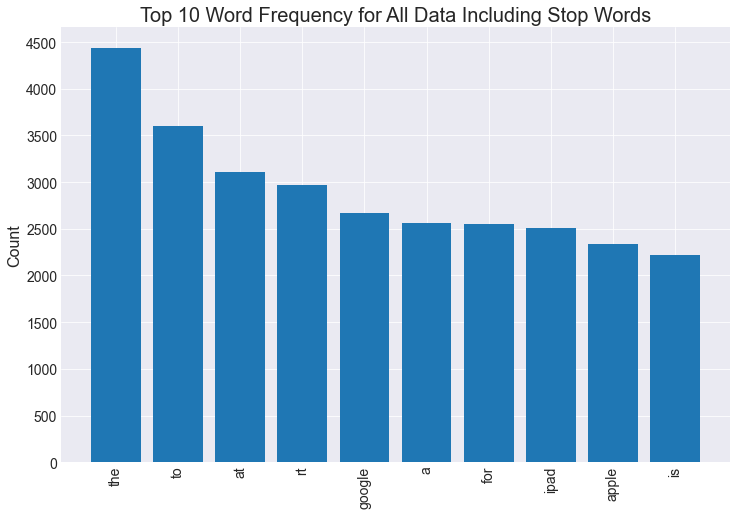

In [31]:
viz.visualize_top_10(freq_dist, "Top 10 Word Frequency for All Data Including Stop Words")

Let's remove the stop words and look for patterns in between the labels and frequencies.

In [32]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [word for word in token_list if word not in stopwords.words('english')]

In [33]:
clean['tokened_text'] = clean['tokened_text'].apply(remove_stopwords)

In [34]:
clean['no_stop_text'] = clean['tokened_text'].apply(lambda x: ' '.join(x))

In [35]:
clean.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text,tokened_text,no_stop_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,i have a 3g iphone after 3 hrs tweeting at ...,"[3g, iphone, 3, hr, tweeting, rise_austin, wa,...",3g iphone 3 hr tweeting rise_austin wa dead ne...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,know about awesome ipad iphone app that yo...,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,can not wait for ipad 2 also they should sal...,"[wait, ipad, 2, also, sale]",wait ipad 2 also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,i hope this years festival is not as crashy a...,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google ...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim oreil...


Let's save a copy of the cleaned data, since this step took so long.

In [36]:
with open('data/clean_tweet_data.pickle', 'wb') as f:
    pickle.dump(clean, f)

In [37]:
with open('data/clean_tweet_data.pickle', 'rb') as file:
    clean = pickle.load(file)

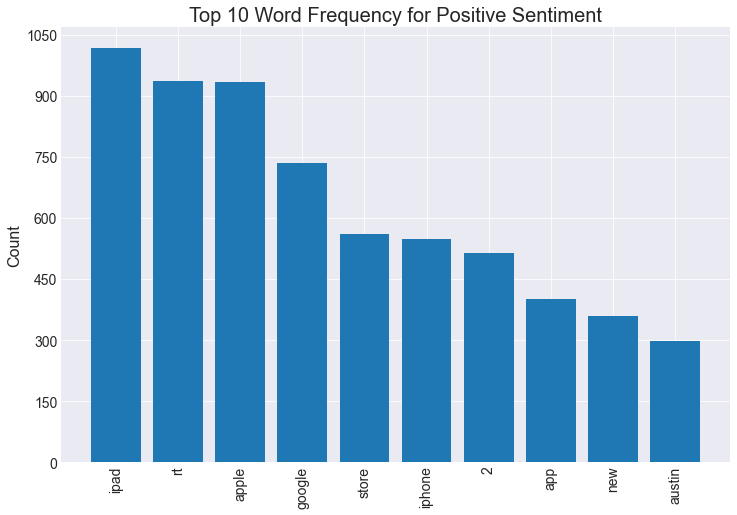

In [38]:
pos_data = clean[clean['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive']['tokened_text'].explode()
pos_freq_dist = FreqDist(pos_data)
viz.visualize_top_10(pos_freq_dist, "Top 10 Word Frequency for Positive Sentiment")

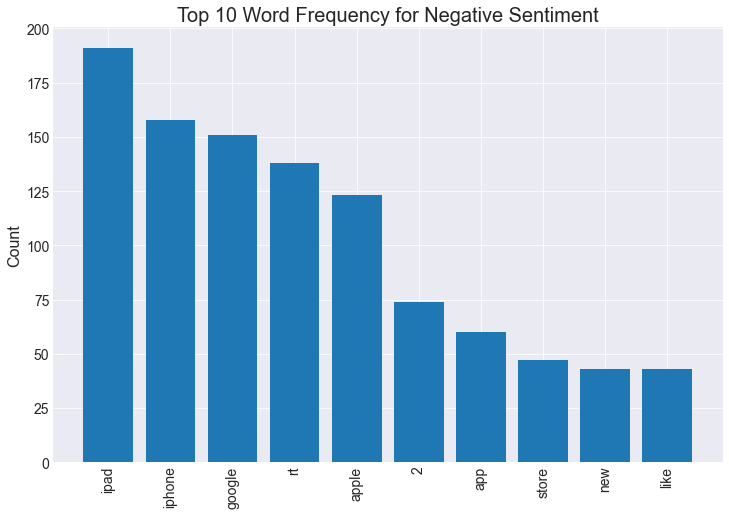

In [39]:
neg_data = clean[clean['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative']['tokened_text'].explode()
neg_freq_dist = FreqDist(neg_data)
viz.visualize_top_10(neg_freq_dist, "Top 10 Word Frequency for Negative Sentiment")

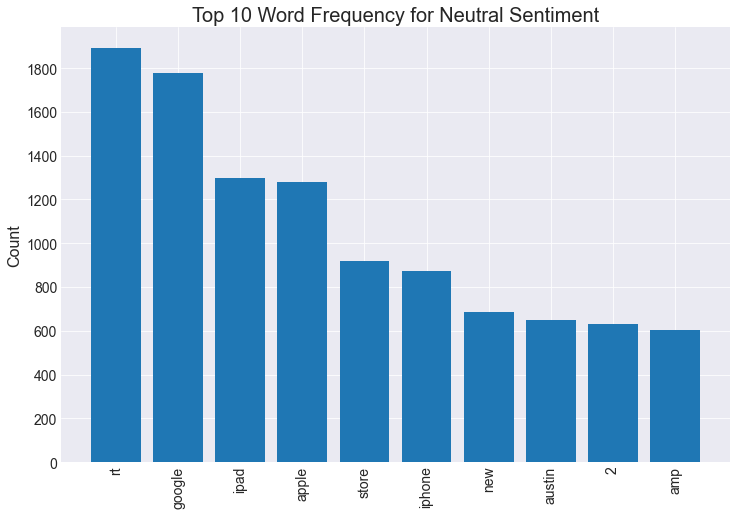

In [40]:
neutral_data = clean[clean['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion']['tokened_text'].explode()
neutral_freq_dist = FreqDist(neutral_data)
viz.visualize_top_10(neutral_freq_dist, "Top 10 Word Frequency for Neutral Sentiment")

Most of the common words are very similar in the different label groups.

## Word Clouds

Below you can see the word cloud for the positive tweets.

In [52]:
pos_tweets = clean[clean['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive']['no_stop_text']
pos_text = " ".join(tweet for tweet in pos_tweets)

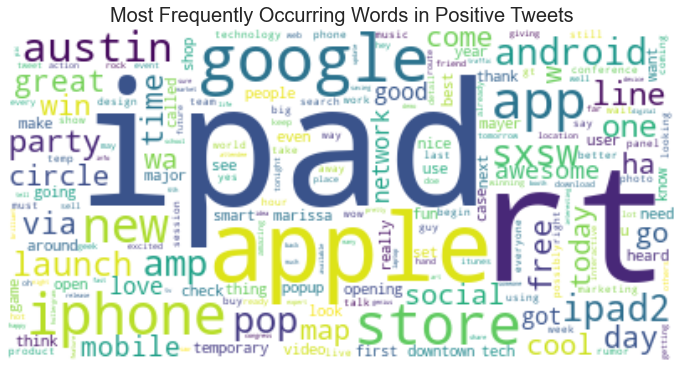

In [53]:
pos_cloud = WordCloud(collocations = False, background_color = 'white').generate(pos_text)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.title('Most Frequently Occurring Words in Positive Tweets')
plt.axis("off")
plt.show()

Below you can see the word cloud for the negative tweets.

In [54]:
neg_tweets = clean[clean['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative']['no_stop_text']
neg_text = " ".join(tweet for tweet in neg_tweets)

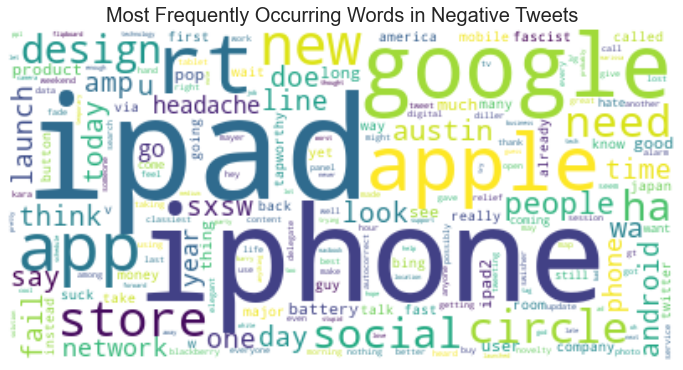

In [55]:
neg_cloud = WordCloud(collocations = False, background_color = 'white').generate(neg_text)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.title('Most Frequently Occurring Words in Negative Tweets')
plt.axis("off")
plt.show()

Below you can see the word cloud for the neutral tweets.

In [56]:
neutral_tweets = clean[clean['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion']['no_stop_text']
neutral_text = " ".join(tweet for tweet in neutral_tweets)

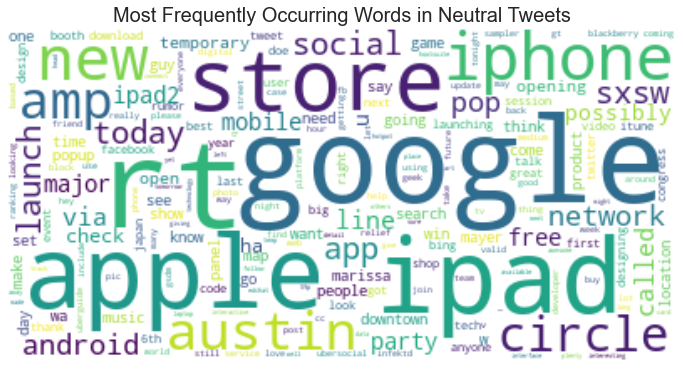

In [57]:
neutral_cloud = WordCloud(collocations = False, background_color = 'white').generate(neutral_text)
plt.imshow(neutral_cloud, interpolation='bilinear')
plt.title('Most Frequently Occurring Words in Neutral Tweets')
plt.axis("off")
plt.show()

## Bigram Visualizations

Often words pairs or bigrams are more different between texts than single words and can give a better sense of what the actual semantic difference between the two are.

In [59]:
bigram_measures = BigramAssocMeasures()
pos_finder = BigramCollocationFinder.from_words(pos_data)
pos_scored = pos_finder.score_ngrams(bigram_measures.raw_freq)

We can see that the top ten bigrams are fairly similar between the datasets.

In [60]:
pos_scored[:10]

[(('ipad', '2'), 0.014054859289484764),
 (('apple', 'store'), 0.0073188898604229415),
 (('iphone', 'app'), 0.004469056640435247),
 (('pop', 'store'), 0.004469056640435247),
 (('google', 'map'), 0.0027850642831697917),
 (('social', 'network'), 0.0027850642831697917),
 (('apple', 'pop'), 0.0026879108779429384),
 (('rt', 'google'), 0.002558373004307134),
 (('new', 'social'), 0.002493604067489232),
 (('rt', 'apple'), 0.00242883513067133)]

In [61]:
neg_finder = BigramCollocationFinder.from_words(neg_data)
neg_scored = neg_finder.score_ngrams(bigram_measures.raw_freq)
neg_scored[:10]

[(('ipad', '2'), 0.00958994708994709),
 (('apple', 'store'), 0.004133597883597883),
 (('iphone', 'app'), 0.003968253968253968),
 (('rt', 'google'), 0.003472222222222222),
 (('ipad', 'design'), 0.0033068783068783067),
 (('design', 'headache'), 0.0028108465608465607),
 (('google', 'circle'), 0.0026455026455026454),
 (('new', 'social'), 0.0026455026455026454),
 (('social', 'network'), 0.00248015873015873),
 (('company', 'america'), 0.0021494708994708994)]

In [62]:
neutral_finder = BigramCollocationFinder.from_words(neutral_data)
neutral_scored = neutral_finder.score_ngrams(bigram_measures.raw_freq)
neutral_scored[:10]

[(('ipad', '2'), 0.008945023883213768),
 (('apple', 'store'), 0.006404637100381058),
 (('social', 'network'), 0.006368857004848203),
 (('new', 'social'), 0.005796375476322522),
 (('called', 'circle'), 0.004687192514804014),
 (('network', 'called'), 0.004615632323738304),
 (('rt', 'google'), 0.004544072132672594),
 (('google', 'launch'), 0.004472511941606884),
 (('major', 'new'), 0.004078930890745478),
 (('pop', 'store'), 0.004043150795212623)]

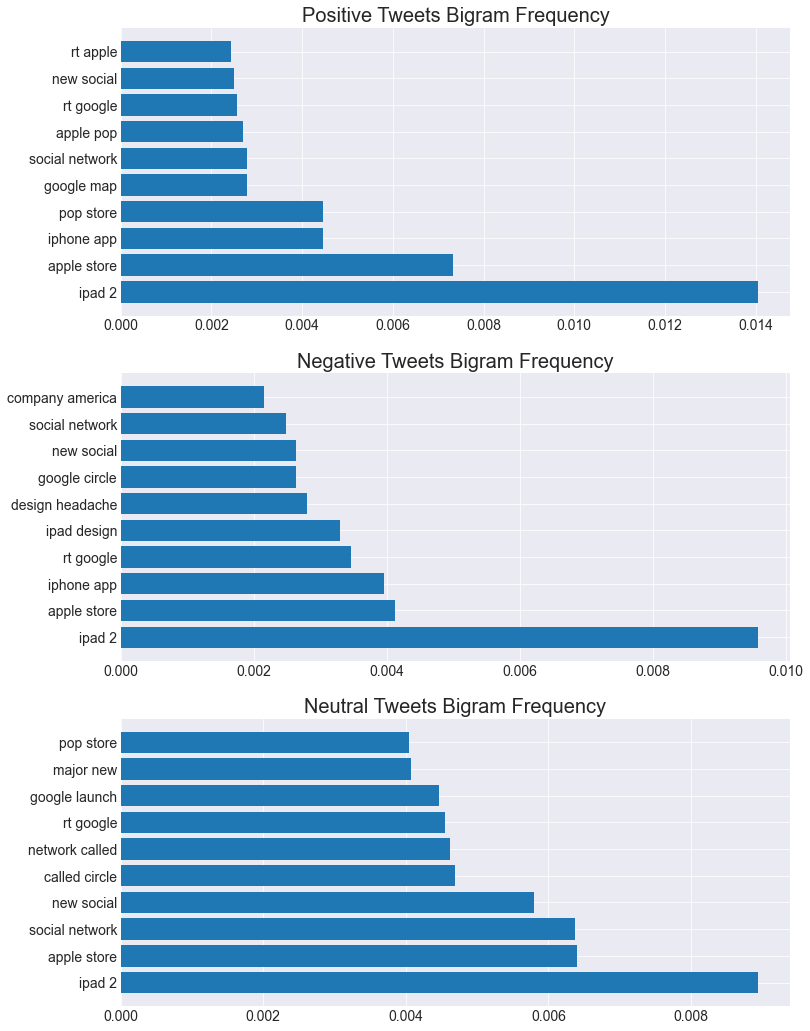

In [63]:
pos_x = [t[0][0]+' '+t[0][1] for t in pos_scored[:10]]
pos_y = [t[1] for t in pos_scored[:10]]
neg_x = [t[0][0]+' '+t[0][1] for t in neg_scored[:10]]
neg_y = [t[1] for t in neg_scored[:10]]
neutral_x = [t[0][0]+' '+t[0][1] for t in neutral_scored[:10]]
neutral_y = [t[1] for t in neutral_scored[:10]]
plt.figure(figsize = (12,18)) 
plt.subplot(3,1,1)
plt.barh(pos_x, pos_y)
plt.title('Positive Tweets Bigram Frequency')
plt.subplot(3,1,2)
plt.barh(neg_x, neg_y)
plt.title('Negative Tweets Bigram Frequency')
plt.subplot(3,1,3)
plt.title('Neutral Tweets Bigram Frequency')
plt.barh(neutral_x, neutral_y)
plt.show()

There is at least some difference in the bigrams. For example, design headaches and ipad design appear in the negative top ten most frequent.

Before we proceed let's make some word clouds from the bigrams.

In [67]:
# Constructing a list of joined bigrams
nltk_tokens = word_tokenize(pos_text)  
bigrams_list = list(bigrams(nltk_tokens))
pos_dictionary = [' '.join(tup) for tup in bigrams_list]

In [70]:
# Getting Frequencies for each joined bigram
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(pos_dictionary)
sum_words = bag_of_words.sum(axis=0) 
pos_words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

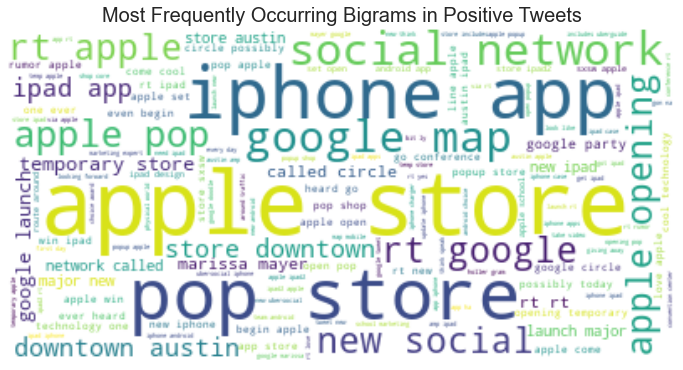

In [71]:
# Making dictionary from lits of tuples and cloud from dictionary
pos_words_dict = dict(pos_words_freq)
pos_bi_cloud = WordCloud(background_color = 'white')
pos_bi_cloud.generate_from_frequencies(pos_words_dict)
plt.title('Most Frequently Occurring Bigrams in Positive Tweets')
plt.imshow(pos_bi_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

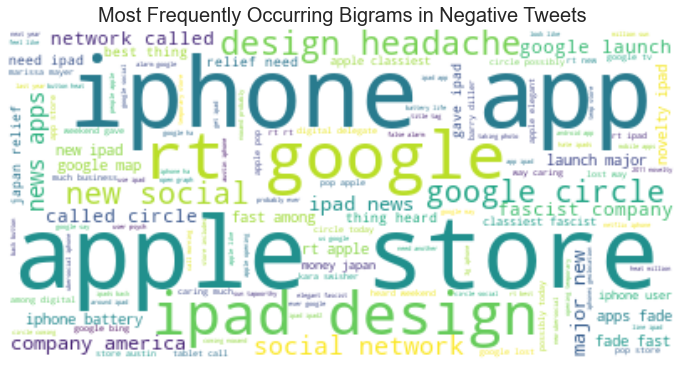

In [72]:
nltk_tokens = word_tokenize(neg_text)  
bigrams_list = list(bigrams(nltk_tokens))
neg_dictionary = [' '.join(tup) for tup in bigrams_list]
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(neg_dictionary)
sum_words = bag_of_words.sum(axis=0) 
neg_words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
neg_words_dict = dict(neg_words_freq)
neg_bi_cloud = WordCloud(background_color = 'white')
neg_bi_cloud.generate_from_frequencies(neg_words_dict)
plt.title('Most Frequently Occurring Bigrams in Negative Tweets')
plt.imshow(neg_bi_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

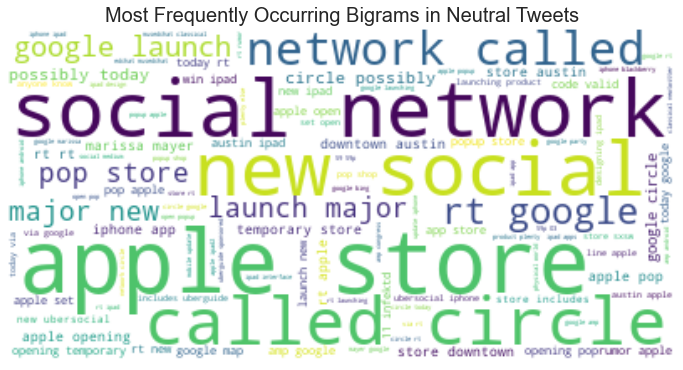

In [73]:
nltk_tokens = word_tokenize(neutral_text)  
bigrams_list = list(bigrams(nltk_tokens))
neutral_dictionary = [' '.join(tup) for tup in bigrams_list]
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(neutral_dictionary)
sum_words = bag_of_words.sum(axis=0) 
neutral_words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
neutral_words_dict = dict(neutral_words_freq)
neutral_bi_cloud = WordCloud(background_color = 'white')
neutral_bi_cloud.generate_from_frequencies(neutral_words_dict)
plt.title('Most Frequently Occurring Bigrams in Neutral Tweets')
plt.imshow(neutral_bi_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Mutual Information Score

Mutual information scores can sometimes give a feel for the differences in the rarer words and phrases in the datasets.

In [74]:
pos_finder.apply_freq_filter(5)
pos_pmi_score = pos_finder.score_ngrams(bigram_measures.pmi)
neg_finder.apply_freq_filter(5)
neg_pmi_score = neg_finder.score_ngrams(bigram_measures.pmi)
neutral_finder.apply_freq_filter(5)
neutral_pmi_score = neutral_finder.score_ngrams(bigram_measures.pmi)

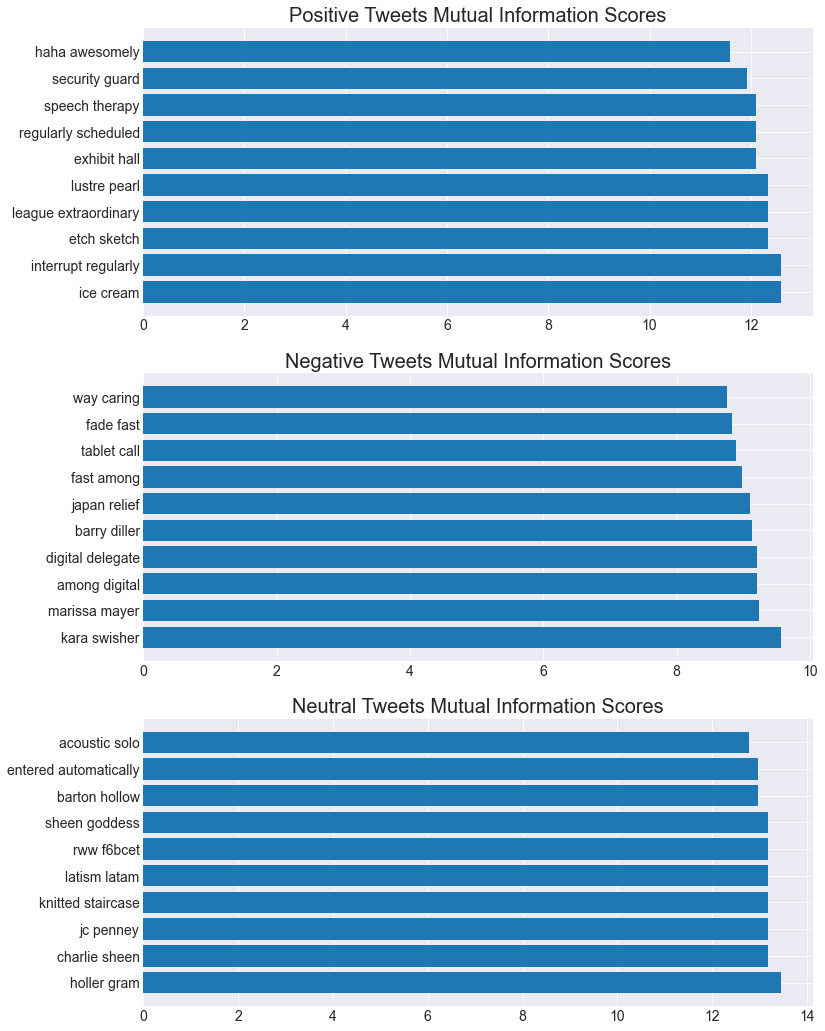

In [75]:
pos_x = [t[0][0]+' '+t[0][1] for t in pos_pmi_score[:10]]
pos_y = [t[1] for t in pos_pmi_score[:10]]
neg_x = [t[0][0]+' '+t[0][1] for t in neg_pmi_score[:10]]
neg_y = [t[1] for t in neg_pmi_score[:10]]
neutral_x = [t[0][0]+' '+t[0][1] for t in neutral_pmi_score[:10]]
neutral_y = [t[1] for t in neutral_pmi_score[:10]]
plt.figure(figsize = (12,18)) 
plt.subplot(3,1,1)
plt.barh(pos_x, pos_y)
plt.title('Positive Tweets Mutual Information Scores')
plt.subplot(3,1,2)
plt.barh(neg_x, neg_y)
plt.title('Negative Tweets Mutual Information Scores')
plt.subplot(3,1,3)
plt.title('Neutral Tweets Mutual Information Scores')
plt.barh(neutral_x, neutral_y)
plt.show()

The mutual information scores are signficantly different. But, it is not clear that this is indicative of the categories or is just noise.